Executive Summary: A one-paragraph description of your project context, key details of your modeling approach, and a summary of your conclusion(s).


Background: A multimedia (text/equations/figures as necessary) description of your project context, including project stakeholders and their needs.
Formulation: A multimedia (text/equations/figures as necessary) description of your project analysis. Must include a formal statement of your optimization problem, details on your model (both functions and distribution) and how you built this model, your optimization strategy (multi-objective? Monte Carlo or FORM? etc.), and method validation results (check for multiple minima, calibration of uncertainty propagation, etc.).
Note that this section must present any and all limitations of your model (functions and distributions), particularly in light of how they affect your Results.
Results: A multimedia (text/equations/figures as necessary) presentation of your results, including observations and analysis of those results in light of your project Background.
Conclusion: A multimedia (text/equations/figures as necessary) description tying specific details from the Results section back to your stakeholder needs (see Background). You must answer the following questions:
“What (if any) insights did you learn about designing for your chosen context and stakeholders?”
“If you did not gain any insights, what future work would be necessary to gain insight into your problem?”
“If you did gain insights, what design decisions would you be inclined to make, based on your current understanding?

# Portfolio Optimization with Stock Price Prediction

## Executive Summary:
In the project, we aim to provide a forward-seeing tool to optimize investment allocation for a given portfolio by utilizing LSTM nueral network to predict future stock price and use sharpe ratio maximization strategy to balance return requirement and risk aversion. In this model, we use a given selection of prices from several industries: Apple, General Motor, Starbucks and Tesla. They represent stocks in several well-operating industries for us to diversify some unsystematic risks. We use Yahoo Finance to pull their data in the past year to perform our modeling. In portfolio optimization model, we use monte-carlo method to generate random weight distribution for 4 stocks and calculate annulized return and standard deviation (volatility in finance) for each of the allocation the choose the maximum sharpe ratio out of them as investment strategy. In the prediction process, we use LSTM neural network to predict stock prices and got explained variance score of 0.99 (best is 1). Therefore combineing these two models we can get multistage portfolio optimization strategies.

## Background
### Finance perspective:
We use closing prices of stocks to measure return. We use annulized return, volatility, and sharpe ratio for calculation. Here we used log daily return rather than arithmatic return, this is because they are not symmetric.
$$ \text{return} = ln(\frac{FV}{PV}) $$
$$ \text{standard deviation} = \sum w_i^2\sigma _i ^2 + 2\sum_{i\neq j}w_i w_j cov_{i,j}$$
$$ \text{sharpe ratio} = \frac{\text{return}}{\text{stdev}} $$

## Stakeholders and Needs:
Ammature investors who want to adjust/ optimize their portfolio.

Needs: Easy operation - 

Portfolio optimization assumes the investor may have some risk aversion and the stock prices may exhibit significant differences between their historical or forecast values and what is experienced. In particular, financial crises are characterized by a significant increase in correlation of stock price movements which may seriously degrade the benefits of diversification.[15]

In a mean-variance optimization framework, accurate estimation of the variance-covariance matrix is paramount. Quantitative techniques that use Monte-Carlo simulation with the Gaussian copula and well-specified marginal distributions are effective.[16] Allowing the modeling process to allow for empirical characteristics in stock returns such as autoregression, asymmetric volatility, skewness, and kurtosis is important. Not accounting for these attributes can lead to severe estimation error in the correlations, variances and covariances that have negative biases (as much as 70% of the true values).[17]



In [1]:
import grama as gr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize

# Define the data pronoun as DF
DF = gr.Intention()

# Set figure options
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [2]:
from pandas_datareader.data import DataReader
from datetime import datetime

In [3]:
tech_list = ['AAPL','GM','SBUX','TSLA']

In [4]:
#grab stock data from yahoo finance
end=datetime.now()
start = datetime(end.year-1,end.month,end.day)
for stock in tech_list:
    globals()[stock] = DataReader(stock,'yahoo',start,end)

In [6]:
company_list = [AAPL,GM,SBUX,TSLA]
company_name = ["APPLE", "GM", "STARBUCKS", "TESLA"]
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

In [7]:
df=pd.concat(company_list,axis=0)

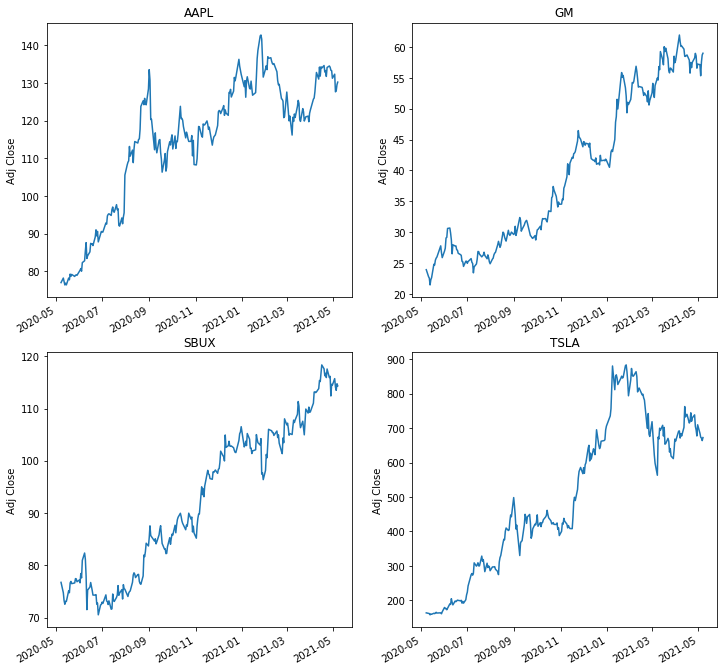

In [8]:
#See closing price in the past year
plt.figure(figsize=(12,8))
plt.subplots_adjust(top=1.25,bottom=1.2)

for i, company in enumerate(company_list,1):
    plt.subplot(2,2,i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f'{tech_list[i-1]}')

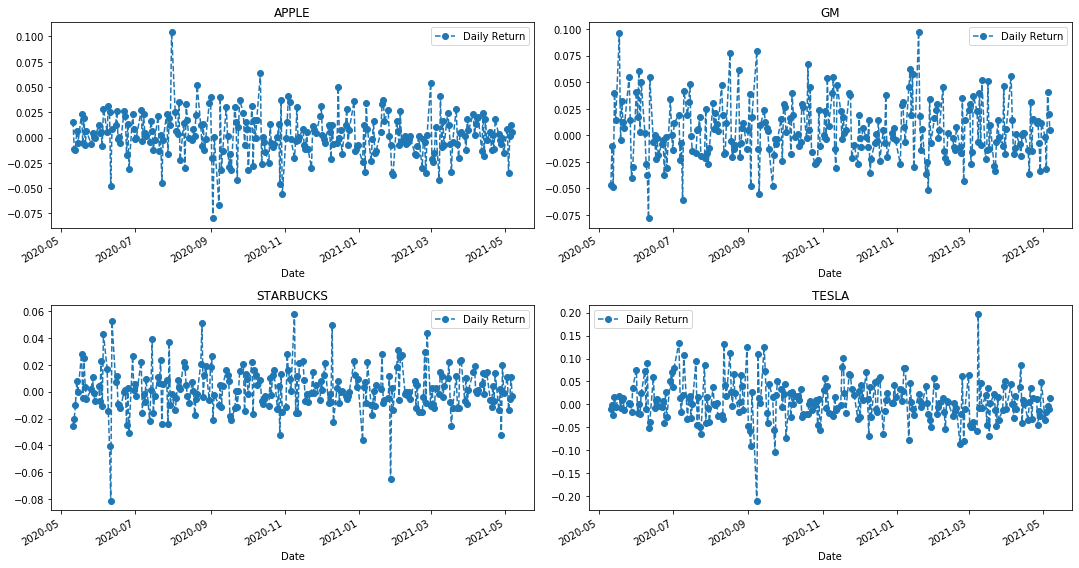

In [10]:
#daily return of the stock on average

for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()
    company['Normed Return'] = company['Adj Close']/company.iloc[0]['Adj Close']

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(8)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GM['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GM')

SBUX['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('STARBUCKS')

TSLA['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('TESLA')

fig.tight_layout()


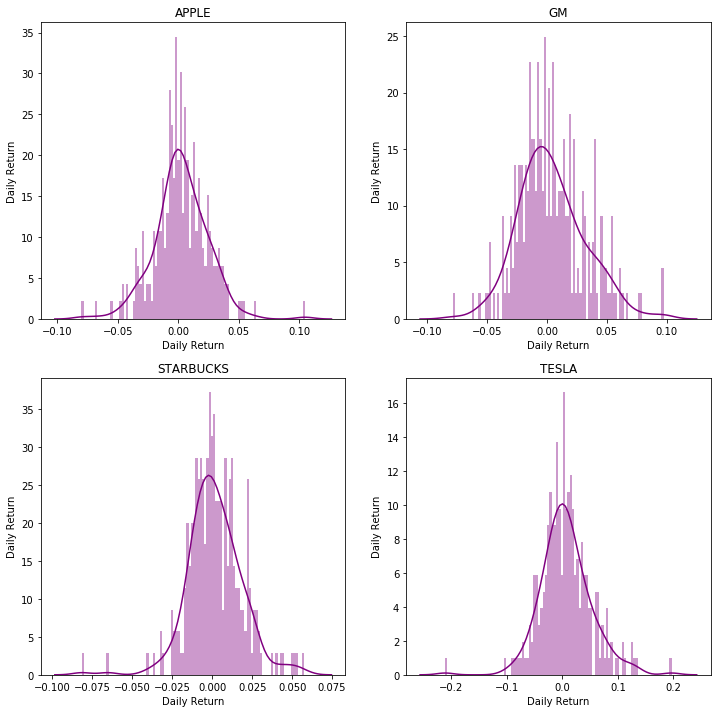

In [11]:
plt.figure(figsize=(12, 12))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    sns.distplot(company['Daily Return'].dropna(), bins=100, color='purple')
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')

In [12]:
#Correlation
closing_df = DataReader(tech_list, 'yahoo', start, end)['Adj Close']
closing_df.head()

Symbols,AAPL,GM,SBUX,TSLA
Date,,,,
2020-05-08,77.013580,23.930000,76.758423,163.884003
2020-05-11,78.225410,22.799999,74.786964,162.257996
2020-05-12,77.331436,22.559999,73.288666,161.882004
2020-05-13,76.397720,21.459999,72.569084,158.192001
2020-05-14,76.867065,22.309999,73.130943,160.666000


In [13]:
#return DF
tech_rets = closing_df.pct_change()
tech_rets.head()

Symbols,AAPL,GM,SBUX,TSLA
Date,,,,
2020-05-08,NaN,NaN,NaN,NaN
2020-05-11,0.015735,-0.047221,-0.025684,-0.009922
2020-05-12,-0.011428,-0.010526,-0.020034,-0.002317
2020-05-13,-0.012074,-0.048759,-0.009818,-0.022794
2020-05-14,0.006143,0.039609,0.007742,0.015639


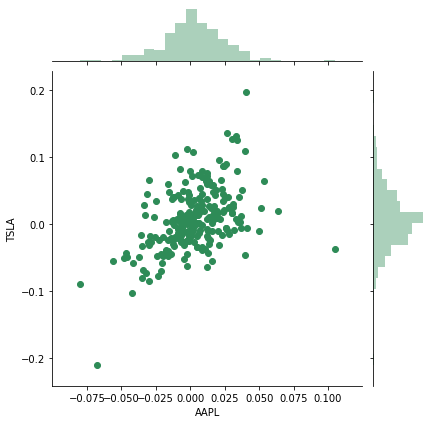

In [14]:
sns.jointplot('AAPL' ,'TSLA', tech_rets, kind='scatter', color='seagreen')

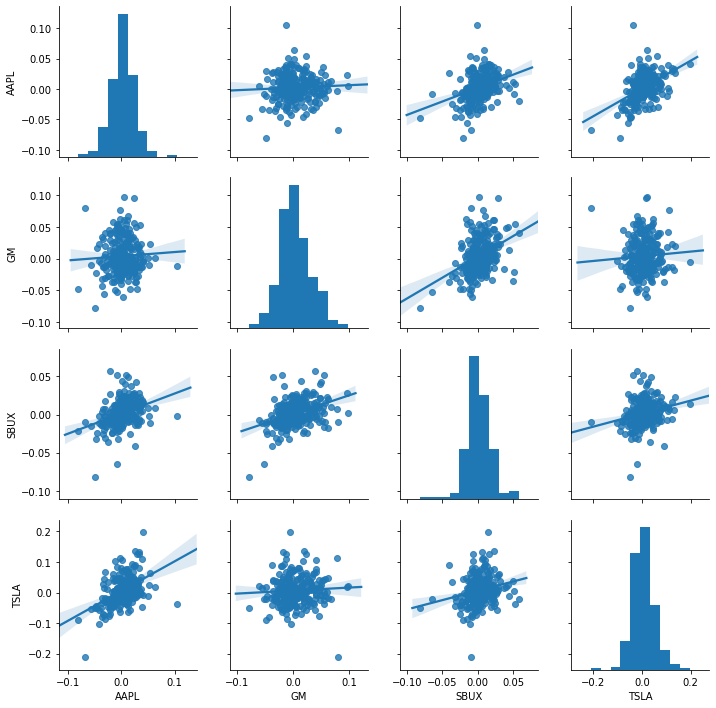

In [15]:
sns.pairplot(tech_rets, kind='reg')


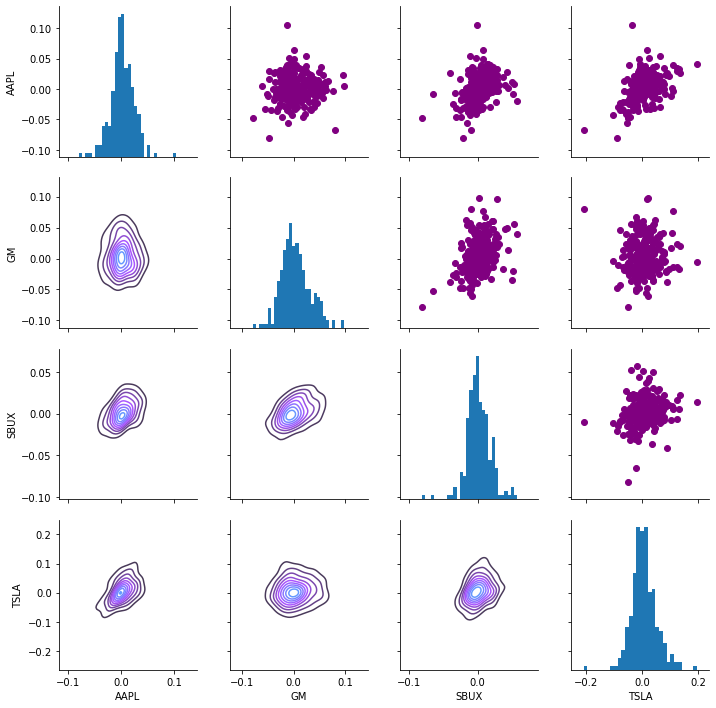

In [16]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) 
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

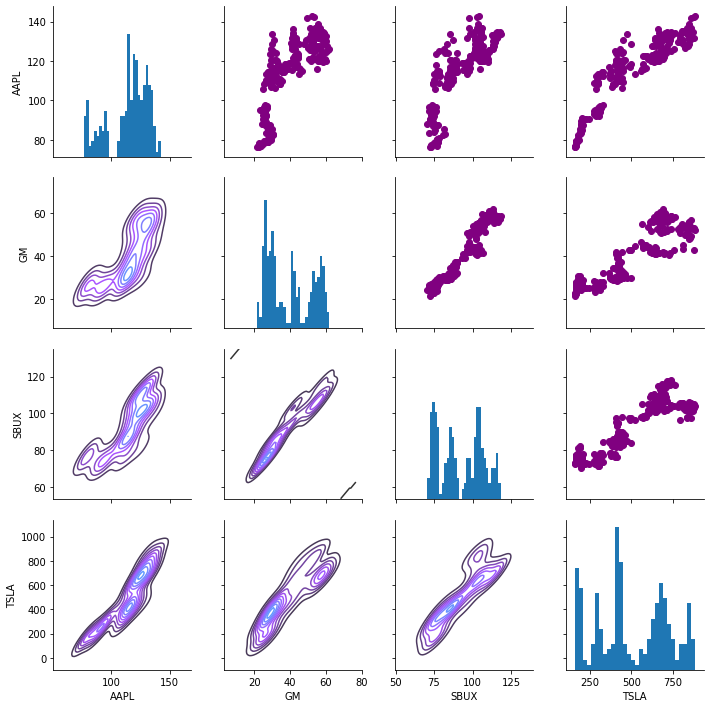

In [17]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

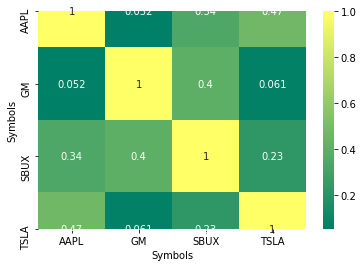

In [18]:
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')


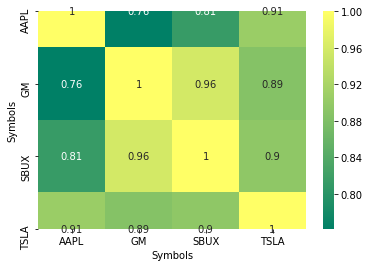

In [19]:
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')


Covariance identifies undiversifiable/systematic risk. It shows the level of risk in stock portfolio.
$$ \text{portfolio variance = } \sum_{i}(w_i \sigma_i)^2 + 2\sum_{i,j,i \neq j}w_i w_j cov_{i,j} $$

Sharpe Ratio: represents the return to risk ratio.

Sharpe Ratio Grading Thresholds:
Less than 1: Bad
1 – 1.99: Adequate/good
2 – 2.99: Very good
Greater than 3: Excellent
$$ \text{sharpe ratio = } \frac{R_p-R_f}{\sigma_p}$$

In [20]:
#an equally distributed portfolio


In [21]:
closing_df

Symbols,AAPL,GM,SBUX,TSLA
Date,,,,
2020-05-08,77.013580,23.930000,76.758423,163.884003
2020-05-11,78.225410,22.799999,74.786964,162.257996
2020-05-12,77.331436,22.559999,73.288666,161.882004
2020-05-13,76.397720,21.459999,72.569084,158.192001
2020-05-14,76.867065,22.309999,73.130943,160.666000
...,...,...,...,...
2021-05-03,132.315247,57.150002,115.720001,684.900024
2021-05-04,127.633202,55.340000,114.110001,673.599976
2021-05-05,127.882790,57.580002,113.480003,670.940002


In [22]:
tech_rets

Symbols,AAPL,GM,SBUX,TSLA
Date,,,,
2020-05-08,NaN,NaN,NaN,NaN
2020-05-11,0.015735,-0.047221,-0.025684,-0.009922
2020-05-12,-0.011428,-0.010526,-0.020034,-0.002317
2020-05-13,-0.012074,-0.048759,-0.009818,-0.022794
2020-05-14,0.006143,0.039609,0.007742,0.015639
...,...,...,...,...
2021-05-03,0.008215,-0.001223,0.010743,-0.034591
2021-05-04,-0.035386,-0.031671,-0.013913,-0.016499
2021-05-05,0.001956,0.040477,-0.005521,-0.003949


In [23]:
import statistics
import math

In [24]:
tech_rets = tech_rets.dropna()
avg_list = []
sd_list = []
for tech in tech_list:
    avg = sum(tech_rets[tech])/len(tech_rets)
    sd = statistics.stdev(tech_rets[tech])
    avg_list.append(avg)
    sd_list.append(sd)
df_summary = pd.DataFrame([avg_list,sd_list],columns=tech_list)
df_summary['type'] = ['avg','stdev']

In [25]:
df_summary = df_summary.reset_index(drop=True).set_index('type')

In [26]:
df_summary

,AAPL,GM,SBUX,TSLA
type,,,,
avg,0.002337,0.003986,0.001734,0.006674
stdev,0.022101,0.027965,0.017073,0.045738


In [27]:
df_summary.loc['avg']/df_summary.loc['stdev']*math.sqrt(252)

AAPL    1.678810
GM      2.262782
SBUX    1.612601
TSLA    2.316422
dtype: float64

In [28]:
tech_rets

Symbols,AAPL,GM,SBUX,TSLA
Date,,,,
2020-05-11,0.015735,-0.047221,-0.025684,-0.009922
2020-05-12,-0.011428,-0.010526,-0.020034,-0.002317
2020-05-13,-0.012074,-0.048759,-0.009818,-0.022794
2020-05-14,0.006143,0.039609,0.007742,0.015639
2020-05-15,-0.005912,0.014343,-0.000404,-0.005178
...,...,...,...,...
2021-05-03,0.008215,-0.001223,0.010743,-0.034591
2021-05-04,-0.035386,-0.031671,-0.013913,-0.016499
2021-05-05,0.001956,0.040477,-0.005521,-0.003949


In [29]:
AAPL

,High,Low,Open,Close,Volume,Adj Close,company_name,Daily Return,Normed Return
Date,,,,,,,,,
2020-05-08,77.587502,76.072502,76.410004,77.532501,133838400.0,77.013580,APPLE,NaN,1.000000
2020-05-11,79.262497,76.809998,77.025002,78.752502,145946400.0,78.225410,APPLE,0.015735,1.015735
2020-05-12,79.922501,77.727501,79.457497,77.852501,162301200.0,77.331436,APPLE,-0.011428,1.004127
2020-05-13,78.987503,75.802498,78.037498,76.912498,200622400.0,76.397720,APPLE,-0.012074,0.992003
2020-05-14,77.447502,75.382500,76.127502,77.385002,158929200.0,76.867065,APPLE,0.006143,0.998098
...,...,...,...,...,...,...,...,...,...
2021-05-03,134.070007,131.830002,132.039993,132.539993,75135100.0,132.315247,APPLE,0.008215,1.718077
2021-05-04,131.490005,126.699997,131.190002,127.849998,137564700.0,127.633202,APPLE,-0.035386,1.657282
2021-05-05,130.449997,127.970001,129.199997,128.100006,84000900.0,127.882790,APPLE,0.001956,1.660523


In [30]:
#Adding allocation (weights)
for stock_df, allo in zip((AAPL,GM,SBUX,TSLA),[.2,.1,.1,.5]):
	stock_df['Allocation'] = stock_df['Normed Return']*allo

In [31]:
#Adding position value
for stock_df in (AAPL,GM,SBUX,TSLA):
	stock_df['Position Value'] = stock_df['Allocation']*1000000

In [32]:
# create list of all position values
all_pos_vals = [AAPL['Position Value'], GM['Position Value'], SBUX['Position Value'], TSLA['Position Value']]

# concatenate the list of position values
portfolio_val = pd.concat(all_pos_vals, axis=1)

# set the column names
portfolio_val.columns = tech_list

# add a total portfolio column
portfolio_val['Total'] = portfolio_val.sum(axis=1)
portfolio_val = portfolio_val.dropna()

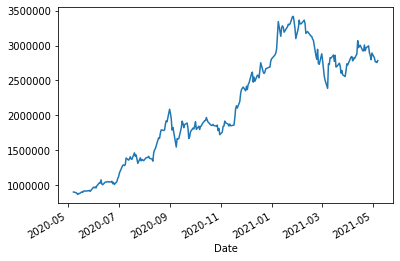

In [33]:
portfolio_val['Total'].plot()

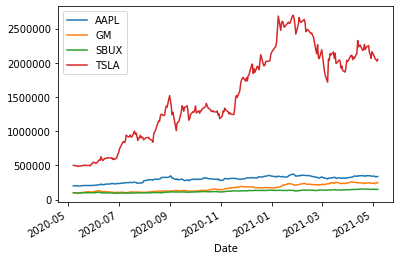

In [34]:
portfolio_val.drop('Total',axis=1).plot()

In [35]:
portfolio_val['Daily Return'] = portfolio_val['Total'].pct_change(1)

In [36]:
# average daily return
portfolio_val['Daily Return'].mean()


0.005098566223137827

In [37]:

# standard deviation
portfolio_val['Daily Return'].std()

0.03440433320978271

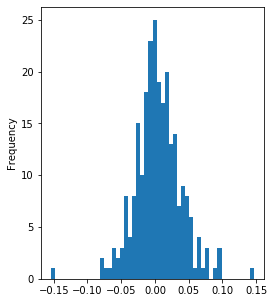

In [38]:
portfolio_val['Daily Return'].plot(kind='hist', bins=50, figsize=(4,5))


In [39]:
md_random_weights = (
    gr.Model('weights')
    
    >>gr.cp_vec_function(
        fun = lambda df: gr.df_make(
        s = df.w1+df.w2+df.w3+df.w4
        ),
        var = ['w1','w2','w3','w4'],
        out = ['s']
    )
    

    >> gr.cp_marginals(
        w1={"dist": "uniform", "loc": 0, "scale": 1},
        w2={"dist": "uniform", "loc": 0, "scale": 1},
        w3={"dist": "uniform", "loc": 0, "scale": 1},
        w4={"dist": "uniform", "loc": 0, "scale": 1},
    )
    
    >> gr.cp_copula_independence()
)
md_random_weights.printpretty()

model: weights

  inputs:
    var_det:
    var_rand:
      w1: (+0) uniform, {'loc': 0, 'scale': 1}
      w2: (+0) uniform, {'loc': 0, 'scale': 1}
      w3: (+0) uniform, {'loc': 0, 'scale': 1}
      w4: (+0) uniform, {'loc': 0, 'scale': 1}
    copula:
        Independence copula
  functions:
    f0: ['w1', 'w2', 'w3', 'w4'] -> ['s']


In [40]:
df_weights = (
    md_random_weights
    >> gr.ev_monte_carlo(n=1e4,df_det='nom')
    >> gr.tf_mutate(W1=DF.w1/DF.s,W2=DF.w2/DF.s,W3=DF.w3/DF.s,W4=DF.w4/DF.s)
    >> gr.tf_select('W1','W2','W3','W4')
)


eval_monte_carlo() is rounding n...


In [41]:
df_weights

,W1,W2,W3,W4
0,0.282367,0.274773,0.132184,0.310676
1,0.046465,0.240036,0.340990,0.372509
2,0.402371,0.173213,0.250147,0.174269
3,0.010549,0.442826,0.234947,0.311678
4,0.181518,0.299162,0.320192,0.199129
...,...,...,...,...
9995,0.013195,0.291921,0.649391,0.045494
9996,0.296394,0.305011,0.316214,0.082381
9997,0.373387,0.332691,0.038192,0.255730
9998,0.326654,0.271535,0.324051,0.077759


In [42]:
df_weights['tot'] = df_weights.W1+df_weights.W2+df_weights.W3+df_weights.W4

In [43]:
stocks = closing_df.copy()

In [48]:
log_ret = np.log(stocks/stocks.shift(1))


In [45]:
def get_ret_vol_sr(weights):
    s1 = log_ret.mean().reset_index(drop=True)
    s2 = weights.reset_index(drop=True)
    ret = np.sum(s1.multiply(s2)) * 252
    vol = np.sqrt(np.dot(s2.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])

In [49]:
md_calc = (
    gr.Model()
    >>gr.cp_function(
        fun = get_ret_vol_sr,
        var = ['W1','W2','W3','W4'],
        out = ['ret','vol','sr']
    )

)


In [50]:
df_all = gr.eval_df(md_calc,df=df_weights)

In [51]:
df_all

,W1,W2,W3,W4,tot,vol,sr,ret
0,0.282367,0.274773,0.132184,0.310676,1.0,0.334283,2.665344,0.890978
1,0.046465,0.240036,0.340990,0.372509,1.0,0.347287,2.609680,0.906308
2,0.402371,0.173213,0.250147,0.174269,1.0,0.283719,2.524069,0.716126
3,0.010549,0.442826,0.234947,0.311678,1.0,0.340002,2.771816,0.942423
4,0.181518,0.299162,0.320192,0.199129,1.0,0.283903,2.736943,0.777025
...,...,...,...,...,...,...,...,...
9995,0.013195,0.291921,0.649391,0.045494,1.0,0.266664,2.233851,0.595686
9996,0.296394,0.305011,0.316214,0.082381,1.0,0.257292,2.626734,0.675839
9997,0.373387,0.332691,0.038192,0.255730,1.0,0.323300,2.709414,0.875953
9998,0.326654,0.271535,0.324051,0.077759,1.0,0.254404,2.586658,0.658055


In [52]:
mx = df_all.iloc[np.argmax(df_all.sr)]

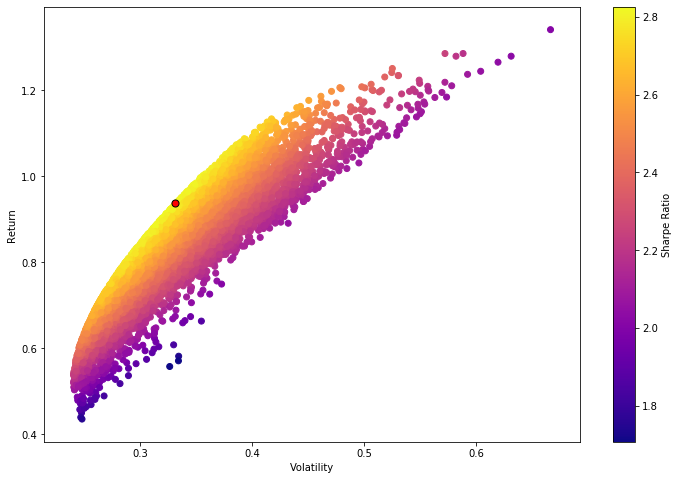

In [53]:
# plot the data
plt.figure(figsize=(12,8))
plt.scatter(df_all.vol,df_all.ret,c=df_all.sr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.scatter(mx.vol, mx.ret, c='red', s=50, edgecolors='black')


In [54]:
def check_sum(weights): 
	return np.sum(weights) - 1

In [55]:
def check_sum(weights): 
	return np.sum(weights) - 1

In [56]:
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25, 0.25, 0.25, 0.25]

In [61]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds,constraints= ({'type':'eq','fun':check_sum}))

In [62]:
opt_results

     fun: -2.82624499670847
     jac: array([-0.00029352, -0.00093016, -0.00028345,  0.00218186])
 message: 'Optimization terminated successfully.'
    nfev: 38
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.20068433, 0.49467195, 0.05906789, 0.24557583])

In [59]:
def get_ret_vol_sr_scipy(weights): 
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])

In [60]:
def neg_sharpe(weights): 
	return get_ret_vol_sr_scipy(weights)[2] * -1

In [65]:
def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_ret.cov()*252,weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])

In [66]:
from scipy.optimize import minimize


In [67]:
def neg_sharpe(weights): 
	return get_ret_vol_sr(weights)[2] * -1

In [68]:
def check_sum(weights): 
	return np.sum(weights) - 1

In [69]:
cons = ({'type':'eq','fun':check_sum})


In [70]:
bounds = ((0,1),(0,1),(0,1),(0,1))


In [71]:
init_guess = [0.25, 0.25, 0.25, 0.25]


In [72]:
opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)


In [76]:
opt_results.x

array([0.20068433, 0.49467195, 0.05906789, 0.24557583])

In [77]:
mx

W1     0.192184
W2     0.508970
W3     0.048196
W4     0.250650
tot    1.000000
vol    0.331544
sr     2.825852
ret    0.936894
Name: 8096, dtype: float64

We can see that they are pretty close

In [79]:
AAPL

,High,Low,Open,Close,Volume,Adj Close,company_name,Daily Return,Normed Return,Allocation,Position Value
Date,,,,,,,,,,,
2020-05-08,77.587502,76.072502,76.410004,77.532501,133838400.0,77.013580,APPLE,NaN,1.000000,0.200000,200000.000000
2020-05-11,79.262497,76.809998,77.025002,78.752502,145946400.0,78.225410,APPLE,0.015735,1.015735,0.203147,203147.055712
2020-05-12,79.922501,77.727501,79.457497,77.852501,162301200.0,77.331436,APPLE,-0.011428,1.004127,0.200825,200825.453988
2020-05-13,78.987503,75.802498,78.037498,76.912498,200622400.0,76.397720,APPLE,-0.012074,0.992003,0.198401,198400.645749
2020-05-14,77.447502,75.382500,76.127502,77.385002,158929200.0,76.867065,APPLE,0.006143,0.998098,0.199620,199619.508944
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,134.070007,131.830002,132.039993,132.539993,75135100.0,132.315247,APPLE,0.008215,1.718077,0.343615,343615.362455
2021-05-04,131.490005,126.699997,131.190002,127.849998,137564700.0,127.633202,APPLE,-0.035386,1.657282,0.331456,331456.351114
2021-05-05,130.449997,127.970001,129.199997,128.100006,84000900.0,127.882790,APPLE,0.001956,1.660523,0.332105,332104.517351


In [80]:
df

,High,Low,Open,Close,Volume,Adj Close,company_name
Date,,,,,,,
2020-05-08,77.587502,76.072502,76.410004,77.532501,133838400.0,77.013580,APPLE
2020-05-11,79.262497,76.809998,77.025002,78.752502,145946400.0,78.225410,APPLE
2020-05-12,79.922501,77.727501,79.457497,77.852501,162301200.0,77.331436,APPLE
2020-05-13,78.987503,75.802498,78.037498,76.912498,200622400.0,76.397720,APPLE
2020-05-14,77.447502,75.382500,76.127502,77.385002,158929200.0,76.867065,APPLE
...,...,...,...,...,...,...,...
2021-05-03,706.000000,680.500000,703.799988,684.900024,27043100.0,684.900024,TESLA
2021-05-04,683.450012,657.700012,678.940002,673.599976,29739300.0,673.599976,TESLA
2021-05-05,685.299988,667.340027,681.059998,670.940002,21901900.0,670.940002,TESLA


In [96]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [84]:
df = df.reset_index()

In [88]:
df['yr'] = df['Date'].dt.year
df['mo'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [90]:
df = df.drop('Date',axis=1)

In [91]:
df

,High,Low,Open,Close,Volume,Adj Close,company_name,yr,mo,day
0,77.587502,76.072502,76.410004,77.532501,133838400.0,77.013580,APPLE,2020,5,8
1,79.262497,76.809998,77.025002,78.752502,145946400.0,78.225410,APPLE,2020,5,11
2,79.922501,77.727501,79.457497,77.852501,162301200.0,77.331436,APPLE,2020,5,12
3,78.987503,75.802498,78.037498,76.912498,200622400.0,76.397720,APPLE,2020,5,13
4,77.447502,75.382500,76.127502,77.385002,158929200.0,76.867065,APPLE,2020,5,14
...,...,...,...,...,...,...,...,...,...,...
1003,706.000000,680.500000,703.799988,684.900024,27043100.0,684.900024,TESLA,2021,5,3
1004,683.450012,657.700012,678.940002,673.599976,29739300.0,673.599976,TESLA,2021,5,4
1005,685.299988,667.340027,681.059998,670.940002,21901900.0,670.940002,TESLA,2021,5,5
1006,681.020020,650.000000,680.760010,663.539978,27784600.0,663.539978,TESLA,2021,5,6


In [132]:
#grab stock data from yahoo finance
now=datetime.now()
end = datetime(now.year,now.month-3,now.day)
start = datetime(now.year-1,now.month,now.day)

for stock in tech_list:
    globals()[stock] = DataReader(stock,'yahoo',start,end)

In [133]:
company_list = [AAPL,GM,SBUX,TSLA]
company_name = ["APPLE", "GM", "STARBUCKS", "TESLA"]
for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

In [134]:
df_train = pd.concat(company_list,axis=0)

In [135]:
df_train  = df_train.reset_index()
df_train['yr'] = df_train['Date'].dt.year
df_train['mo'] = df_train['Date'].dt.month
df_train['day'] = df_train['Date'].dt.day

In [136]:
df_train = df_train.drop('Date',axis=1)

In [137]:
df_train

,High,Low,Open,Close,Volume,Adj Close,company_name,yr,mo,day
0,77.587502,76.072502,76.410004,77.532501,133838400.0,77.013580,APPLE,2020,5,8
1,79.262497,76.809998,77.025002,78.752502,145946400.0,78.225410,APPLE,2020,5,11
2,79.922501,77.727501,79.457497,77.852501,162301200.0,77.331436,APPLE,2020,5,12
3,78.987503,75.802498,78.037498,76.912498,200622400.0,76.397720,APPLE,2020,5,13
4,77.447502,75.382500,76.127502,77.385002,158929200.0,76.867065,APPLE,2020,5,14
...,...,...,...,...,...,...,...,...,...,...
759,878.080017,853.059998,877.020020,854.690002,18343500.0,854.690002,TESLA,2021,2,3
760,856.500000,833.419983,855.000000,849.989990,15812700.0,849.989990,TESLA,2021,2,4
761,864.770020,838.969971,845.000000,852.229980,18566600.0,852.229980,TESLA,2021,2,5
762,877.770020,854.750000,869.669983,863.419983,20161700.0,863.419983,TESLA,2021,2,8


In [138]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [139]:
enc.fit(df_train.company_name)

LabelEncoder()

In [140]:
df_train.company_name = enc.transform(df_train.company_name)

In [141]:
df_train

,High,Low,Open,Close,Volume,Adj Close,company_name,yr,mo,day
0,77.587502,76.072502,76.410004,77.532501,133838400.0,77.013580,0,2020,5,8
1,79.262497,76.809998,77.025002,78.752502,145946400.0,78.225410,0,2020,5,11
2,79.922501,77.727501,79.457497,77.852501,162301200.0,77.331436,0,2020,5,12
3,78.987503,75.802498,78.037498,76.912498,200622400.0,76.397720,0,2020,5,13
4,77.447502,75.382500,76.127502,77.385002,158929200.0,76.867065,0,2020,5,14
...,...,...,...,...,...,...,...,...,...,...
759,878.080017,853.059998,877.020020,854.690002,18343500.0,854.690002,3,2021,2,3
760,856.500000,833.419983,855.000000,849.989990,15812700.0,849.989990,3,2021,2,4
761,864.770020,838.969971,845.000000,852.229980,18566600.0,852.229980,3,2021,2,5
762,877.770020,854.750000,869.669983,863.419983,20161700.0,863.419983,3,2021,2,8


In [142]:
from sklearn.preprocessing import MinMaxScaler


In [143]:
X_train = df_train.drop('Adj Close',axis=1)

In [144]:
y_train = df_train['Adj Close']

In [145]:
scaler=MinMaxScaler(feature_range=(0,1))

In [146]:
scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [148]:
X = scaler.transform(X_train)

In [162]:
y = y_train.values

In [164]:
scaler_y = MinMaxScaler(feature_range=(0,1))

In [166]:
y = scaler_y.fit_transform(y.reshape(-1,1))

In [154]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


Using TensorFlow backend.


In [155]:
X = np.reshape(X, (X.shape[0],X.shape[1],1))


In [168]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, y, epochs=10, batch_size=8, verbose=2)

Epoch 1/10
 - 1s - loss: 0.0058
Epoch 2/10
 - 1s - loss: 5.6702e-04
Epoch 3/10
 - 1s - loss: 3.8704e-04
Epoch 4/10
 - 1s - loss: 5.1016e-04
Epoch 5/10
 - 1s - loss: 3.1746e-04
Epoch 6/10
 - 1s - loss: 5.2296e-04
Epoch 7/10
 - 1s - loss: 2.2345e-04
Epoch 8/10
 - 1s - loss: 3.7849e-04
Epoch 9/10
 - 1s - loss: 1.7872e-04
Epoch 10/10
 - 1s - loss: 1.2853e-04


In [169]:
#grab stock data from yahoo finance
now=datetime.now()
end = now
start = datetime(now.year,now.month-3,now.day)

for stock in tech_list:
    globals()[stock] = DataReader(stock,'yahoo',start,end)

In [170]:
df_test = pd.concat(company_list,axis=0)

In [171]:
df_test  = df_test.reset_index()
df_test['yr'] = df_test['Date'].dt.year
df_test['mo'] = df_test['Date'].dt.month
df_test['day'] = df_test['Date'].dt.day

In [172]:
df_test = df_test.drop('Date',axis=1)

In [173]:
df_test.company_name = enc.transform(df_test.company_name)

In [175]:
X_pred = df_test.drop('Adj Close',axis=1)

In [176]:
y_true = df_test['Adj Close'].values

In [177]:
X_pred = scaler.transform(X_pred)

In [178]:
y_true = scaler_y.transform(y_true.reshape(-1,1))

In [180]:
X_pred = np.reshape(X_pred, (X_pred.shape[0],X_pred.shape[1],1))


In [181]:
closing_price = model.predict(X_pred)

In [182]:
closing_price = scaler_y.inverse_transform(closing_price)


In [ ]:
closing_price = scaler_y.inverse_transform(closing_price)


In [186]:
df_test['pred'] = closing_price

In [187]:
df_test

,High,Low,Open,Close,Volume,Adj Close,company_name,yr,mo,day,pred
0,77.587502,76.072502,76.410004,77.532501,133838400.0,77.013580,0,2020,5,8,81.027435
1,79.262497,76.809998,77.025002,78.752502,145946400.0,78.225410,0,2020,5,11,83.253731
2,79.922501,77.727501,79.457497,77.852501,162301200.0,77.331436,0,2020,5,12,86.026314
3,78.987503,75.802498,78.037498,76.912498,200622400.0,76.397720,0,2020,5,13,90.181244
4,77.447502,75.382500,76.127502,77.385002,158929200.0,76.867065,0,2020,5,14,83.763321
...,...,...,...,...,...,...,...,...,...,...,...
759,878.080017,853.059998,877.020020,854.690002,18343500.0,854.690002,3,2021,2,3,807.257629
760,856.500000,833.419983,855.000000,849.989990,15812700.0,849.989990,3,2021,2,4,791.982788
761,864.770020,838.969971,845.000000,852.229980,18566600.0,852.229980,3,2021,2,5,794.989563
762,877.770020,854.750000,869.669983,863.419983,20161700.0,863.419983,3,2021,2,8,809.140076


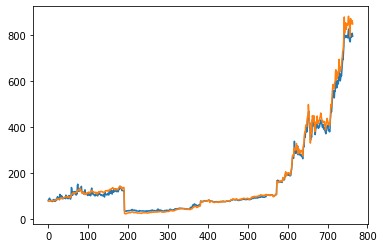

In [185]:
plt.plot(closing_price)
plt.plot(df_test['Adj Close'])

company_name
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Adj Close, dtype: object

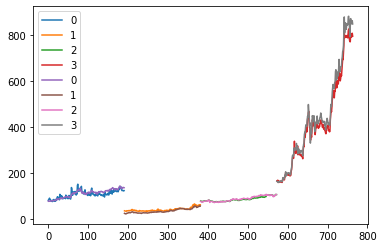

In [192]:
df_test.groupby('company_name')['pred'].plot(legend=True)
df_test.groupby('company_name')['Adj Close'].plot(legend=True)


In [195]:
from sklearn.metrics import confusion_matrix

In [201]:
from sklearn.metrics import explained_variance_score


In [202]:
explained_variance_score(df_test['Adj Close'].values, df_test.pred.values)

0.9940521879900128